In [1]:
%pylab inline
import numpy
import matplotlib.pylab as pylab
import time

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


# Allan Variance
## Characterisation and measurement of radiometer stability

### Aim
Characterise radiometer noise

### Algorithm
For a spectrometer with K channels, the average Allan variance spectrum can be obtained by summing the variance of each individual channel

**Step 1**   
The signal in each channel, $d_k[n]$, at the $n$ may be normalised by subtracting a zero level and then by dividing the difference by the temporal average of each channel   
$s_k[n]=\frac{d_k[n]-z_k}{<d_k[n]-z_k>_n} ; z_k=\frac{1}{N}\sum\limits^N_{n=1} d_k[n]$

**Step 2**   
Calculate the Allan variance of each spectral channel by convolving the signal with a Haar wavelet.   
$\sigma^2_{A,k}(L) = <(S_k(M)-S_k(M+1)-<S_k(M)-S_k(M+1)>_n)^2>_n$;   
$S_k(M)=\frac{1}{l}\sum\limits^{(M+1)l}_{n=Ml+1} s_k[n]$

**Step 3**   
Allan variance is the average over all channels   
$\sigma^2_{A}(T)=\frac{1}{K}\sum\limits^K_{k=1} \sigma^2_{A,k}(L)$

In [2]:
def allanVariance_math(data):
    """
        Analyzes radiometer stability by calculating Allan variance plot, as
        proposed by Rau, Schneider & Vowinkel
        - see "Characterization and Measurement of Radiometer Stability"
        @param data: measurements spaced at regular intervals
        @return: (Ks, sA2) - the number of integration intervals and the Allan variance,
        respectively.
    """ 
    # Functions to calculate the Allan variance:
    def R(i, K, x):
        s = 0
        for n in range(K):
            s += x[i*K + n]
        return s/float(K)

    def s2(K, x):
        M = len(x)/K-1
        s = 0
        for i in range(M):
            s += (R(i+1, K, x) - R(i, K, x))**2
        return s/(2.*M)

    # Calculate the Allan variances vs. integration intervals:
    Ks = range(1,len(data)/3)
    sA2 = [s2(K, data) for K in Ks]
    return Ks, sA2

### Implementation of the Allan Variance algorithm

$L=1\cdot \Delta t \rightarrow l=1 \rightarrow \frac{1}{l}\sum\limits^{(M+1)l}_{n=Ml+1}S_k(t_n)$

$\begin{array}{lcrc|c|} Ml+1 : M & = & 1 & l+1 & 2 \\ & = & 2 & 2l+1 & 3  \\ & = & 3 & 3l+1 & 4  \\ & = & 4 & 4l+1 & 5 \end{array}$        $\begin{array}{lcrc|c|} (M+1)l : M & = & 1 & 2l & 2 \\ & = & 2 & 3l & 3  \\ & = & 3 & 4l & 4  \\ & = & 4 & 5l & 5 \end{array}$


$L=2\cdot \Delta t \rightarrow l=2 \rightarrow \frac{1}{l}\sum\limits^{(M+1)l}_{n=Ml+1}S_k(t_n)$

$\begin{array}{lcrc|c|} Ml+1 : M & = & 1 & l+1 & 3 \\ & = & 2 & 2l+1 & 5  \\ & = & 3 & 3l+1 & 7  \\ & = & 4 & 4l+1 & 9 \end{array}$        $\begin{array}{lcrc|c|} (M+1)l : M & = & 1 & 2l & 4 \\ & = & 2 & 3l & 6  \\ & = & 3 & 4l & 8  \\ & = & 4 & 5l & 10 \end{array}$


$L=3\cdot \Delta t \rightarrow l=3 \rightarrow \frac{1}{l}\sum\limits^{(M+1)l}_{n=Ml+1}S_k(t_n)$

$\begin{array}{lcrc|c|} Ml+1 : M & = & 1 & l+1 & 4 \\ & = & 2 & 2l+1 & 7  \\ & = & 3 & 3l+1 & 10  \\ & = & 4 & 4l+1 & 13 \end{array}$        $\begin{array}{lcrc|c|} (M+1)l : M & = & 1 & 2l & 6 \\ & = & 2 & 3l & 9  \\ & = & 3 & 4l & 12  \\ & = & 4 & 5l & 15 \end{array}$


Consider the time series data for a single channel, $S_k[t_{1...N}]$    
|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|...|   
|...|...|...|...|...|...|...|...|   
$l=1 \rightarrow S(M)$ = each element   
|... ...|... ...|... ...|... ...|   
$l=2 \rightarrow S(M)$ = average of every 2 consecutive elements as chunks   
|... ... ...|... ... ...|... ... ...|   
$l=3 \rightarrow S(M)$ = average of every 3 consecutive elements as chunks

$l$ provides the chunk size and $M$ the number of chunks that the array can be divided into.   
Thus the new algorithm:
 - reshape the array so column values form the chunk elements and the rows the number of chunks
 - get the average of each of these chunks
 - compute the diff
 - subtract the mean of the diff
 - square the results to get the allan variance

In [3]:
def allanVariance_pattern(timeseries,dt=1):
    Allan=[]
    lag = numpy.arange(1,len(timeseries)/3)*dt
    for l in range(1,len(timeseries)/3):
        a = timeseries.copy()
        a.resize((int(len(timeseries)/l), l))
        chunks = numpy.mean(a, axis=1)
        diff = numpy.diff(chunks[1:])
        Allan.append(numpy.mean((diff-numpy.mean(diff))**2))

    Allan=numpy.array(Allan)
    return [Allan, lag]

## Demo
Different types of noise dominates the total power output: white noise has a slope = 1; flicker (pink) noise has a slope = 0 ; drift noise has a slope = -1

In [4]:
from scipy import stats
# Pink noise generator
def pink1d(n, rvs=stats.norm.rvs):
    k = min(int(floor(log(n)/log(2))), 6)
    pink = zeros((n,), float)
    m = 1
    for i in range(k):
        p = int(ceil(float(n) / m))
        pink += repeat(rvs(size=p), m,axis=0)[:n]
        m <<= 1

    return pink/k

Calculating Allan Variance for 1000 sec timeseries
	Time = 0.096824 [sec]
Calculating Allan Variance for 1500 sec timeseries
	Time = 0.111091 [sec]
Calculating Allan Variance for 1000 sec timeseries
	Time = 0.098794 [sec]
Calculating Allan Variance for 1500 sec timeseries
	Time = 0.112794 [sec]
Calculating Allan Variance for 1000 sec timeseries
	Time = 0.098001 [sec]
Calculating Allan Variance for 1500 sec timeseries
	Time = 0.112551 [sec]


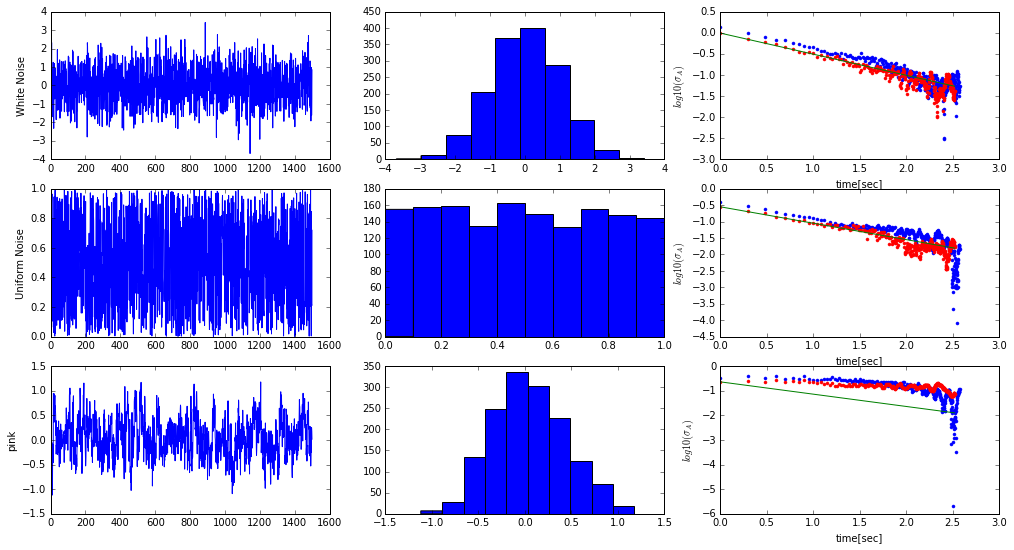

In [5]:
pylab.figure(figsize=[17,9])
pylab.clf()

N=1000
white_noise=numpy.random.randn(N)
print('Calculating Allan Variance for %d sec timeseries' % N)
stime = time.time()
K, sA2 = allanVariance_math(white_noise)
print('\tTime = %f [sec]' % (time.time()-stime))
N=1500
print('Calculating Allan Variance for %d sec timeseries' % N)
white_noise=numpy.random.randn(N)
[allan, lag]  = allanVariance_pattern(white_noise)
print('\tTime = %f [sec]' % (time.time()-stime))
pylab.subplot(331)
pylab.plot(white_noise)
pylab.ylabel('White Noise')
pylab.subplot(332)
pylab.hist(white_noise)
pylab.subplot(333)
pylab.plot(log10(lag[allan>0]), 0.5*log10(allan[allan>0]), "b.", log10(K), 0.5*log10(sA2), "r.", log10(K), 0.5*log10(sA2[0]/K), "g-")
pylab.ylabel(r"$log10(\sigma_A)$")
pylab.xlabel('time[sec]')


# uniform
N=1000
uniform_noise=numpy.random.random(N)
print('Calculating Allan Variance for %d sec timeseries' % N)
stime = time.time()
K, sA2 = allanVariance_math(uniform_noise)
print('\tTime = %f [sec]' % (time.time()-stime))
N=1500
print('Calculating Allan Variance for %d sec timeseries' % N)
uniform_noise=numpy.random.random(N)
[allan, lag]  = allanVariance_pattern(uniform_noise)
print('\tTime = %f [sec]' % (time.time()-stime))
pylab.subplot(334)
pylab.plot(uniform_noise)
pylab.ylabel('Uniform Noise')
pylab.subplot(335)
pylab.hist(uniform_noise)
pylab.subplot(336)
pylab.plot(log10(lag[allan>0]), 0.5*log10(allan[allan>0]), "b.", log10(K), 0.5*log10(sA2), "r.", log10(K), 0.5*log10(sA2[0]/K), "g-")
pylab.ylabel(r"$log10(\sigma_A)$")
pylab.xlabel('time[sec]')

## pink / flicker
# uniform
N=1000
pink_noise=pink1d(N)
print('Calculating Allan Variance for %d sec timeseries' % N)
stime = time.time()
K, sA2 = allanVariance_math(pink_noise)
print('\tTime = %f [sec]' % (time.time()-stime))
N=1500
print('Calculating Allan Variance for %d sec timeseries' % N)
pink_noise=pink1d(N)
[allan, lag]  = allanVariance_pattern(pink_noise)
print('\tTime = %f [sec]' % (time.time()-stime))
pylab.subplot(337)
pylab.plot(pink_noise)
pylab.ylabel('pink')
pylab.subplot(338)
pylab.hist(pink_noise)
pylab.subplot(339)
pylab.plot(log10(lag[allan>0]), 0.5*log10(allan[allan>0]), "b.", log10(K), 0.5*log10(sA2), "r.", log10(K), 0.5*log10(sA2[0]/K), "g-")
pylab.ylabel(r"$log10(\sigma_A)$")
pylab.xlabel('time[sec]')